# Encode and model and predict

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
%run '../modules/mongodb.py'
%run '../modules/xgboost.py'

In [3]:
color_code = {
    'Red': 0,
    'Blue': 1
}

In [4]:
mongodb = MongoDB()
mongoufc = mongodb.client()['ufc']
cur = mongoufc.processing.find({})
original = pd.DataFrame(cur)
original.drop(columns=['_id'], inplace=True)
original.head()

,r_odds,b_odds,r_ev,b_ev,winner,title_bout,weight_class,gender,no_of_rounds,b_current_lose_streak,...,r_height_cms,r_reach_cms,r_weight_lbs,r_age,b_age,empty_arena,b_match_weightclass_rank,r_match_weightclass_rank,b_pound_for_pound_rank,better_rank
0,-150,130,66.667,130,0,False,Light Heavyweight,MALE,5,0,...,187.96,193.04,205,37,29,1,10,5,<NA>,Red
1,170,-200,170.0,50,1,False,Welterweight,MALE,3,2,...,180.34,193.04,170,33,32,1,<NA>,<NA>,<NA>,neither
2,110,-130,110.0,76,1,False,Middleweight,MALE,3,1,...,190.5,195.58,205,34,32,1,<NA>,<NA>,<NA>,neither
3,-675,475,14.815,475,0,False,Lightweight,MALE,3,1,...,175.26,182.88,155,29,32,1,<NA>,<NA>,<NA>,neither
4,-135,115,74.074,115,1,False,Lightweight,MALE,3,0,...,175.26,177.8,155,28,33,1,<NA>,<NA>,<NA>,neither


In [5]:
lol = original.isna().sum()
lol[lambda x : x > 0]

Series([], dtype: int64)

In [6]:
original = original.replace(r'^\s*$', np.nan, regex=True)
original = original.replace('<NA>', np.nan, regex=True)
df = original.copy()
df.head()

,r_odds,b_odds,r_ev,b_ev,winner,title_bout,weight_class,gender,no_of_rounds,b_current_lose_streak,...,r_height_cms,r_reach_cms,r_weight_lbs,r_age,b_age,empty_arena,b_match_weightclass_rank,r_match_weightclass_rank,b_pound_for_pound_rank,better_rank
0,-150,130,66.667,130,0,False,Light Heavyweight,MALE,5,0,...,187.96,193.04,205,37,29,1,10,5,NaN,Red
1,170,-200,170.0,50,1,False,Welterweight,MALE,3,2,...,180.34,193.04,170,33,32,1,NaN,NaN,NaN,neither
2,110,-130,110.0,76,1,False,Middleweight,MALE,3,1,...,190.5,195.58,205,34,32,1,NaN,NaN,NaN,neither
3,-675,475,14.815,475,0,False,Lightweight,MALE,3,1,...,175.26,182.88,155,29,32,1,NaN,NaN,NaN,neither
4,-135,115,74.074,115,1,False,Lightweight,MALE,3,0,...,175.26,177.8,155,28,33,1,NaN,NaN,NaN,neither


## String to correct type

In [7]:
lol = original.isna().sum() # this is normal
indexes = lol[lambda x : x > 0].index
indexes = list(indexes)
lol[lambda x : x > 0]

b_avg_sig_str_landed         898
b_avg_sig_str_pct            739
b_avg_sub_att                803
b_avg_td_landed              804
b_avg_td_pct                 813
r_avg_sig_str_landed         443
r_avg_sig_str_pct            348
r_avg_sub_att                348
r_avg_td_landed              348
r_avg_td_pct                 358
b_match_weightclass_rank    3891
r_match_weightclass_rank    3450
b_pound_for_pound_rank      4715
dtype: int64

In [8]:
avgs = list(filter(lambda x : 'avg' in x, indexes))
avgs

['b_avg_sig_str_landed',
 'b_avg_sig_str_pct',
 'b_avg_sub_att',
 'b_avg_td_landed',
 'b_avg_td_pct',
 'r_avg_sig_str_landed',
 'r_avg_sig_str_pct',
 'r_avg_sub_att',
 'r_avg_td_landed',
 'r_avg_td_pct']

In [9]:
for avg in avgs:
    df[avg] = df[avg].astype('float32')
    
df[avgs].dtypes

b_avg_sig_str_landed    float32
b_avg_sig_str_pct       float32
b_avg_sub_att           float32
b_avg_td_landed         float32
b_avg_td_pct            float32
r_avg_sig_str_landed    float32
r_avg_sig_str_pct       float32
r_avg_sub_att           float32
r_avg_td_landed         float32
r_avg_td_pct            float32
dtype: object

In [10]:
df[avgs].isna().sum()

b_avg_sig_str_landed    898
b_avg_sig_str_pct       739
b_avg_sub_att           803
b_avg_td_landed         804
b_avg_td_pct            813
r_avg_sig_str_landed    443
r_avg_sig_str_pct       348
r_avg_sub_att           348
r_avg_td_landed         348
r_avg_td_pct            358
dtype: int64

In [11]:
for avg in avgs:
    df.loc[df[avg].isna(), avg] = df[avg].median()
df[avgs].isna().sum()

b_avg_sig_str_landed    0
b_avg_sig_str_pct       0
b_avg_sub_att           0
b_avg_td_landed         0
b_avg_td_pct            0
r_avg_sig_str_landed    0
r_avg_sig_str_pct       0
r_avg_sub_att           0
r_avg_td_landed         0
r_avg_td_pct            0
dtype: int64

In [12]:
streaks = list(filter(lambda x : 'streak' in x, list(df.columns)))
print(df[streaks].dtypes)
df[streaks] = df[streaks].astype('int32')
print(df[streaks].dtypes)

df[streaks].isna().sum()

b_current_lose_streak    object
b_current_win_streak     object
b_longest_win_streak     object
r_current_lose_streak    object
r_current_win_streak     object
r_longest_win_streak     object
dtype: object
b_current_lose_streak    int32
b_current_win_streak     int32
b_longest_win_streak     int32
r_current_lose_streak    int32
r_current_win_streak     int32
r_longest_win_streak     int32
dtype: object


b_current_lose_streak    0
b_current_win_streak     0
b_longest_win_streak     0
r_current_lose_streak    0
r_current_win_streak     0
r_longest_win_streak     0
dtype: int64

In [13]:
intables = ['winner', 'no_of_rounds', 'losses', 
            'rounds_fought', 'title_bouts', 'win_by_', 'wins', 'age',
            'empty_arena', 'r_match_weightclass_rank', 'b_match_weightclass_rank', 'b_pound_for_pound_rank',
            'odds']

for it in intables:
    columns = list(filter(lambda col : it in col, list(df.columns)))
    for col in columns:
        if 'rank' in col:
            df[col] = df[col].astype('Int32') # the majority of rank has missing values
        else:
            df[col] = df[col].astype('int32')

In [14]:
floatables = ['ev', 'cms', 'lbs']

for it in floatables:
    columns = list(filter(lambda col : it in col, list(df.columns)))
    for col in columns:
        df[col] = df[col].astype('float32')

In [15]:
stances = pd.concat([df['r_stance'], df['b_stance']])
stances.unique()

array(['Orthodox', 'Southpaw', 'Switch', 'Open Stance', 'nan', 'Switch '],
      dtype=object)

In [16]:
df['title_bout'] = df['title_bout'].astype('bool').astype('int32')

In [17]:
df['r_stance'] = df['r_stance'].astype('category')
df['b_stance'] = df['b_stance'].astype('category')
df['weight_class'] = df['weight_class'].astype('category')
df['gender'] = df['gender'].astype('category')
df['better_rank'] = df['better_rank'].astype('category')

## Model without encoding with biass

<AxesSubplot: xlabel='winner', ylabel='count'>

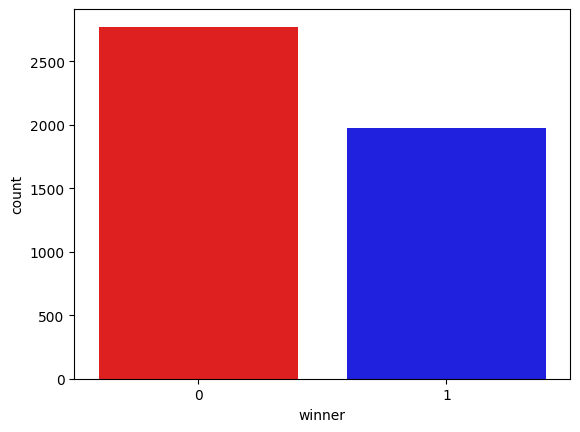

In [18]:
noencoding = df.copy()
sns.countplot(x='winner', data=noencoding, palette=['r', 'b'])

Accuracy: 61.05%


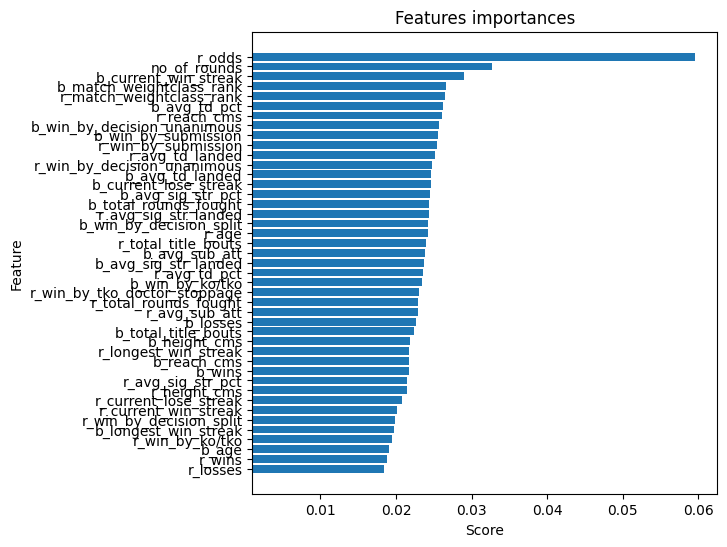

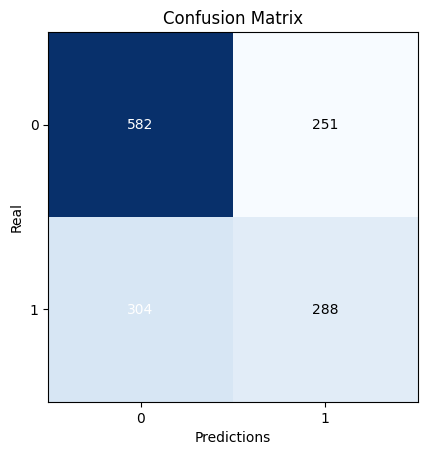

In [19]:
## tunning
columns = [
          'r_ev', 
         'b_ev', 
            'b_odds', 
          'b_pound_for_pound_rank',
            'r_weight_lbs', 
           'b_weight_lbs',
          'r_win_by_decision_majority',
           'b_win_by_decision_majority',
           'empty_arena',
           'title_bout',
            'n_of_rounds',
            'b_win_by_tko_doctor_stoppage'
          ]

noencoding.drop(columns=columns, inplace=True, errors='ignore')

weights = classifier(noencoding, 'winner')

In [20]:
to_save = noencoding.copy()
to_save = to_save.astype(str)
# to_save = to_save.replace(np.nan, '', regex=True)
to_save[to_save.isna()]

mongoufc.noencoding_biassed_ensamble.drop()
mongodb.send(to_save, mongoufc.noencoding_biassed_ensamble)

## Model without encoding without biass

2774 1974
0.2883922134102379
(4748, 60)
(3948, 60)


<AxesSubplot: xlabel='winner', ylabel='count'>

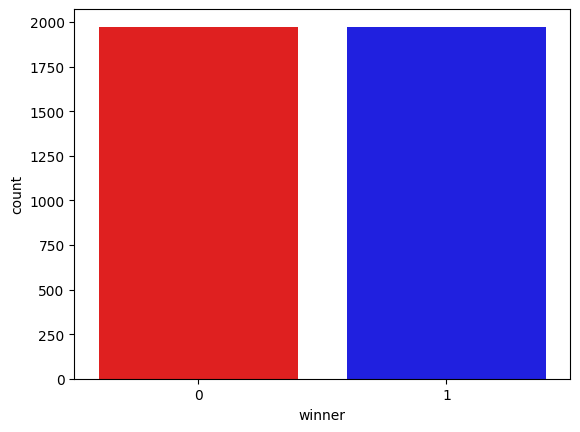

In [21]:
noencoding = df.copy()

n_red = len(noencoding[noencoding['winner'] == color_code['Red']])
n_blue = len(noencoding[noencoding['winner'] == color_code['Blue']])

print(n_red, n_blue)

frac = abs(n_red - n_blue) / max(n_red, n_blue)
target = color_code['Red'] if n_red > n_blue else color_code['Blue']


print(frac)

print(noencoding.shape)

noencoding.drop(noencoding[noencoding['winner'] == target].sample(frac=frac, random_state=1).index, inplace=True)

print(noencoding.shape)

sns.countplot(x='winner', data=noencoding, palette=['r', 'b'])

Accuracy: 57.81%


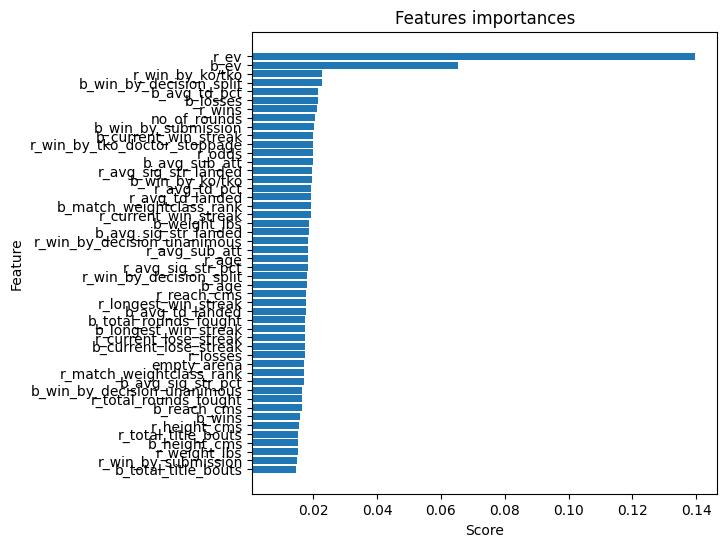

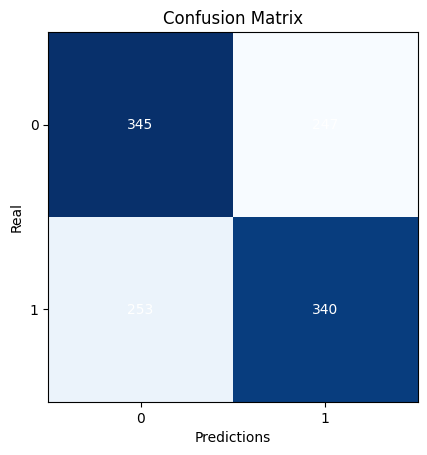

In [22]:
## tunning
columns = [
          #'r_ev', 
         #'b_ev', 
            'b_odds', 
          'b_pound_for_pound_rank',
           # 'r_weight_lbs', 
           #'b_weight_lbs',
         'r_win_by_decision_majority',
           'b_win_by_decision_majority',
           #'empty_arena',
           'title_bout',
            #'n_of_rounds',
            'b_win_by_tko_doctor_stoppage',
          ]

noencoding.drop(columns=columns, inplace=True, errors='ignore')

weights = classifier(noencoding, 'winner')

In [23]:
to_save = noencoding.copy()
to_save = to_save.astype(str)
# to_save = to_save.replace(np.nan, '', regex=True)
to_save[to_save.isna()]

mongoufc.noencoding_ensamble.drop()
mongodb.send(to_save, mongoufc.noencoding_ensamble)

In [ ]:
## Model with encoding with biass